## Outline
1. Import libraries and initialise global variables
2. Data preprocessing
    - Load in dataset
    - Buffered prefetching
    - Data augmentation
    - Rescaling
3. Load base model
    - MobileNet V3
    - DenseNet
    - ResNet50 201
4. Create complete model
5. Train model
6. Findings and results

In [1]:
import tensorflow as tf

# https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from gen_results import gen_save_cr_cm # Load test results
import pandas as pd
import seaborn as sns

import json
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [1]:
import model_create_save
from tqdm import tqdm

In [2]:
# Initialise sets
BATCH_SIZE = 64
EPOCHS = 50
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)
LABELS = ["female", "male"]

In [3]:
def gen_models_all_sets(EPOCHS=EPOCHS):
    for set_no in tqdm(range(1, 11), "Loading sets..."):
        # Set 1 to Set 10
        target = 'preprocessing/cv_datasets/set{}'.format(set_no) + "/"
        model_create_save.reset(target, EPOCHS)
        print("Training...")
        model_create_save.find_best_weights_and_history(set_no)
        print("Saving...")
        print("--------------------------------")

In [4]:
gen_models_all_sets()

Loading sets...:   0%|          | 0/10 [00:00<?, ?it/s]

Setting preprocessing_fp...
Setting number of epochs...
Loading train and validation data...
Found 23220 files belonging to 2 classes.
Found 11610 files belonging to 2 classes.
Loading prefetch and data augmentation variable initialised...
Loading base models...
Flag set to: True
Generating models...
Training...
Epoch 1/50
726/726 [==============================] - 23s 28ms/step - loss: 17.7590 - accuracy: 0.6957 - val_loss: 3.3104 - val_accuracy: 0.7728
Epoch 2/50
726/726 [==============================] - 19s 26ms/step - loss: 2.5104 - accuracy: 0.7397 - val_loss: 1.1744 - val_accuracy: 0.7868
Epoch 3/50
726/726 [==============================] - 19s 26ms/step - loss: 1.0750 - accuracy: 0.7494 - val_loss: 0.7531 - val_accuracy: 0.7852
Epoch 4/50
726/726 [==============================] - 19s 27ms/step - loss: 0.7505 - accuracy: 0.7520 - val_loss: 0.6303 - val_accuracy: 0.7711
Epoch 5/50
726/726 [==============================] - 19s 27ms/step - loss: 0.6459 - accuracy: 0.7499 - val_l

Loading sets...:  10%|█         | 1/10 [1:50:26<16:33:59, 6626.62s/it]

Saving...
--------------------------------
Setting preprocessing_fp...
Setting number of epochs...
Loading train and validation data...
Found 23220 files belonging to 2 classes.
Found 11610 files belonging to 2 classes.
Generating models...
Training...
Epoch 1/50
726/726 [==============================] - 38s 49ms/step - loss: 17.5594 - accuracy: 0.6942 - val_loss: 3.0851 - val_accuracy: 0.7815
Epoch 2/50
726/726 [==============================] - 35s 48ms/step - loss: 2.3536 - accuracy: 0.7463 - val_loss: 1.1490 - val_accuracy: 0.7566
Epoch 3/50
726/726 [==============================] - 35s 48ms/step - loss: 1.0298 - accuracy: 0.7480 - val_loss: 0.7268 - val_accuracy: 0.7837
Epoch 4/50
726/726 [==============================] - 35s 48ms/step - loss: 0.7336 - accuracy: 0.7489 - val_loss: 0.6168 - val_accuracy: 0.7788
Epoch 5/50
726/726 [==============================] - 35s 48ms/step - loss: 0.6340 - accuracy: 0.7580 - val_loss: 0.5766 - val_accuracy: 0.7718
Epoch 6/50
726/726 [======

Loading sets...:  20%|██        | 2/10 [4:17:42<16:11:55, 7289.47s/it]

Saving...
--------------------------------
Setting preprocessing_fp...
Setting number of epochs...
Loading train and validation data...
Found 23220 files belonging to 2 classes.
Found 11610 files belonging to 2 classes.
Generating models...
Training...
Epoch 1/50
726/726 [==============================] - 38s 50ms/step - loss: 17.8835 - accuracy: 0.6835 - val_loss: 3.3493 - val_accuracy: 0.7740
Epoch 2/50
726/726 [==============================] - 35s 49ms/step - loss: 2.5348 - accuracy: 0.7444 - val_loss: 1.1772 - val_accuracy: 0.7803
Epoch 3/50
726/726 [==============================] - 35s 48ms/step - loss: 1.0720 - accuracy: 0.7539 - val_loss: 0.7687 - val_accuracy: 0.7680
Epoch 4/50
726/726 [==============================] - 35s 49ms/step - loss: 0.7518 - accuracy: 0.7455 - val_loss: 0.6131 - val_accuracy: 0.7855
Epoch 5/50
726/726 [==============================] - 35s 48ms/step - loss: 0.6364 - accuracy: 0.7544 - val_loss: 0.5619 - val_accuracy: 0.7884
Epoch 6/50
726/726 [======

Loading sets...:  30%|███       | 3/10 [6:45:19<15:05:18, 7759.75s/it]

Saving...
--------------------------------
Setting preprocessing_fp...
Setting number of epochs...
Loading train and validation data...
Found 23220 files belonging to 2 classes.
Found 11610 files belonging to 2 classes.
Generating models...
Training...
Epoch 1/50
726/726 [==============================] - 38s 49ms/step - loss: 17.6501 - accuracy: 0.6792 - val_loss: 3.1537 - val_accuracy: 0.7739
Epoch 2/50
726/726 [==============================] - 35s 49ms/step - loss: 2.3911 - accuracy: 0.7436 - val_loss: 1.1319 - val_accuracy: 0.7811
Epoch 3/50
726/726 [==============================] - 35s 49ms/step - loss: 1.0376 - accuracy: 0.7458 - val_loss: 0.7831 - val_accuracy: 0.7386
Epoch 4/50
726/726 [==============================] - 35s 49ms/step - loss: 0.7338 - accuracy: 0.7515 - val_loss: 0.6184 - val_accuracy: 0.7766
Epoch 5/50
726/726 [==============================] - 36s 49ms/step - loss: 0.6332 - accuracy: 0.7494 - val_loss: 0.5586 - val_accuracy: 0.7845
Epoch 6/50
726/726 [======

Loading sets...:  40%|████      | 4/10 [9:12:19<13:27:46, 8077.73s/it]

Saving...
--------------------------------
Setting preprocessing_fp...
Setting number of epochs...
Loading train and validation data...
Found 23220 files belonging to 2 classes.
Found 11610 files belonging to 2 classes.
Generating models...
Training...
Epoch 1/50
726/726 [==============================] - 38s 49ms/step - loss: 17.9222 - accuracy: 0.6777 - val_loss: 3.4006 - val_accuracy: 0.7802
Epoch 2/50
726/726 [==============================] - 35s 48ms/step - loss: 2.5895 - accuracy: 0.7469 - val_loss: 1.2102 - val_accuracy: 0.7745
Epoch 3/50
726/726 [==============================] - 35s 48ms/step - loss: 1.1035 - accuracy: 0.7460 - val_loss: 0.7548 - val_accuracy: 0.7869
Epoch 4/50
726/726 [==============================] - 35s 48ms/step - loss: 0.7573 - accuracy: 0.7486 - val_loss: 0.6142 - val_accuracy: 0.7889
Epoch 5/50
726/726 [==============================] - 35s 48ms/step - loss: 0.6446 - accuracy: 0.7487 - val_loss: 0.5563 - val_accuracy: 0.7876
Epoch 6/50
726/726 [======

Loading sets...:  50%|█████     | 5/10 [11:39:09<11:31:26, 8297.30s/it]

Saving...
--------------------------------
Setting preprocessing_fp...
Setting number of epochs...
Loading train and validation data...
Found 23220 files belonging to 2 classes.
Found 11610 files belonging to 2 classes.
Generating models...
Training...
Epoch 1/50
726/726 [==============================] - 38s 49ms/step - loss: 17.6908 - accuracy: 0.6910 - val_loss: 3.3432 - val_accuracy: 0.7444
Epoch 2/50
726/726 [==============================] - 35s 48ms/step - loss: 2.5120 - accuracy: 0.7447 - val_loss: 1.1831 - val_accuracy: 0.7674
Epoch 3/50
726/726 [==============================] - 35s 48ms/step - loss: 1.0680 - accuracy: 0.7434 - val_loss: 0.7391 - val_accuracy: 0.7858
Epoch 4/50
726/726 [==============================] - 35s 48ms/step - loss: 0.7400 - accuracy: 0.7542 - val_loss: 0.6214 - val_accuracy: 0.7736
Epoch 5/50
726/726 [==============================] - 35s 48ms/step - loss: 0.6373 - accuracy: 0.7554 - val_loss: 0.5466 - val_accuracy: 0.7925
Epoch 6/50
726/726 [======

Loading sets...:  60%|██████    | 6/10 [14:06:11<9:23:39, 8454.94s/it] 

Saving...
--------------------------------
Setting preprocessing_fp...
Setting number of epochs...
Loading train and validation data...
Found 23220 files belonging to 2 classes.
Found 11610 files belonging to 2 classes.
Generating models...
Training...
Epoch 1/50
726/726 [==============================] - 39s 49ms/step - loss: 17.5866 - accuracy: 0.6931 - val_loss: 3.2347 - val_accuracy: 0.7858
Epoch 2/50
726/726 [==============================] - 35s 48ms/step - loss: 2.4850 - accuracy: 0.7432 - val_loss: 1.1740 - val_accuracy: 0.7829
Epoch 3/50
726/726 [==============================] - 35s 49ms/step - loss: 1.0746 - accuracy: 0.7434 - val_loss: 0.7536 - val_accuracy: 0.7953
Epoch 4/50
726/726 [==============================] - 35s 49ms/step - loss: 0.7573 - accuracy: 0.7438 - val_loss: 0.6120 - val_accuracy: 0.7896
Epoch 5/50
726/726 [==============================] - 35s 49ms/step - loss: 0.6488 - accuracy: 0.7479 - val_loss: 0.5630 - val_accuracy: 0.7873
Epoch 6/50
726/726 [======

Loading sets...:  70%|███████   | 7/10 [16:33:43<7:08:41, 8573.94s/it]

Saving...
--------------------------------
Setting preprocessing_fp...
Setting number of epochs...
Loading train and validation data...
Found 23220 files belonging to 2 classes.
Found 11610 files belonging to 2 classes.
Generating models...
Training...
Epoch 1/50
726/726 [==============================] - 39s 49ms/step - loss: 17.5915 - accuracy: 0.6890 - val_loss: 3.1818 - val_accuracy: 0.7808
Epoch 2/50
726/726 [==============================] - 36s 49ms/step - loss: 2.4367 - accuracy: 0.7425 - val_loss: 1.1421 - val_accuracy: 0.7786
Epoch 3/50
726/726 [==============================] - 35s 48ms/step - loss: 1.0525 - accuracy: 0.7518 - val_loss: 0.7381 - val_accuracy: 0.7808
Epoch 4/50
726/726 [==============================] - 35s 48ms/step - loss: 0.7456 - accuracy: 0.7524 - val_loss: 0.6065 - val_accuracy: 0.7873
Epoch 5/50
726/726 [==============================] - 35s 49ms/step - loss: 0.6353 - accuracy: 0.7565 - val_loss: 0.5523 - val_accuracy: 0.7870
Epoch 6/50
726/726 [======

Loading sets...:  80%|████████  | 8/10 [19:01:23<4:48:39, 8659.70s/it]

Saving...
--------------------------------
Setting preprocessing_fp...
Setting number of epochs...
Loading train and validation data...
Found 23220 files belonging to 2 classes.
Found 11610 files belonging to 2 classes.
Generating models...
Training...
Epoch 1/50
726/726 [==============================] - 38s 49ms/step - loss: 17.8687 - accuracy: 0.6943 - val_loss: 3.3934 - val_accuracy: 0.7587
Epoch 2/50
726/726 [==============================] - 35s 49ms/step - loss: 2.5665 - accuracy: 0.7440 - val_loss: 1.2226 - val_accuracy: 0.7595
Epoch 3/50
726/726 [==============================] - 35s 49ms/step - loss: 1.0863 - accuracy: 0.7425 - val_loss: 0.7515 - val_accuracy: 0.7795
Epoch 4/50
726/726 [==============================] - 35s 48ms/step - loss: 0.7502 - accuracy: 0.7467 - val_loss: 0.6293 - val_accuracy: 0.7663
Epoch 5/50
726/726 [==============================] - 35s 49ms/step - loss: 0.6401 - accuracy: 0.7526 - val_loss: 0.6142 - val_accuracy: 0.7457
Epoch 6/50
726/726 [======

Loading sets...:  90%|█████████ | 9/10 [21:28:30<2:25:10, 8710.06s/it]

Saving...
--------------------------------
Setting preprocessing_fp...
Setting number of epochs...
Loading train and validation data...
Found 23220 files belonging to 2 classes.
Found 11610 files belonging to 2 classes.
Generating models...
Training...
Epoch 1/50
726/726 [==============================] - 38s 49ms/step - loss: 17.8048 - accuracy: 0.6987 - val_loss: 3.3416 - val_accuracy: 0.7779
Epoch 2/50
726/726 [==============================] - 35s 48ms/step - loss: 2.5458 - accuracy: 0.7428 - val_loss: 1.1907 - val_accuracy: 0.7844
Epoch 3/50
726/726 [==============================] - 36s 49ms/step - loss: 1.0829 - accuracy: 0.7524 - val_loss: 0.7717 - val_accuracy: 0.7748
Epoch 4/50
726/726 [==============================] - 35s 49ms/step - loss: 0.7517 - accuracy: 0.7583 - val_loss: 0.6202 - val_accuracy: 0.7855
Epoch 5/50
726/726 [==============================] - 35s 48ms/step - loss: 0.6395 - accuracy: 0.7531 - val_loss: 0.5832 - val_accuracy: 0.7710
Epoch 6/50
726/726 [======

Loading sets...: 100%|██████████| 10/10 [23:54:44<00:00, 8608.50s/it] 

Saving...
--------------------------------


# Model Analysis

## Plot Accuracy and Loss graphs over 50 epochs

In [12]:
def plot_acc_loss_graph(history):
    acc = []
    val_acc = []
    loss = []
    val_loss = []

    acc += history['accuracy']
    val_acc += history['val_accuracy']

    loss += history['loss']
    val_loss += history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [13]:
# Load histories
with open('history/model_tl_history_mobile.json') as f:
    history_mobile = json.load(f)
with open('history/model_tl_history_dense.json') as f:
    history_dense = json.load(f)
with open('history/model_tl_history_res.json') as f:
    history_res = json.load(f)

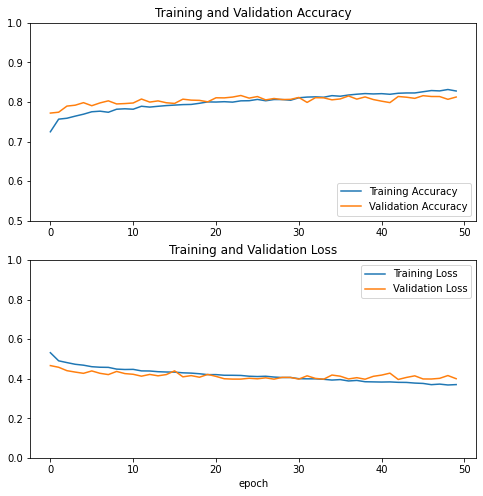

In [14]:
# Accuracy and Loss graphs for MobileNet
plot_acc_loss_graph(history_mobile)

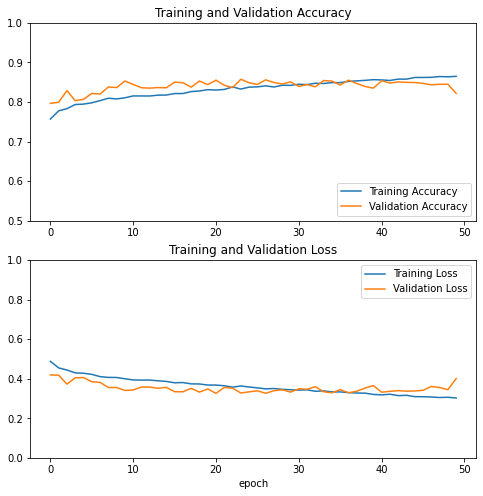

In [17]:
# Accuracy and Loss graphs for DenseNet
plot_acc_loss_graph(history_dense)

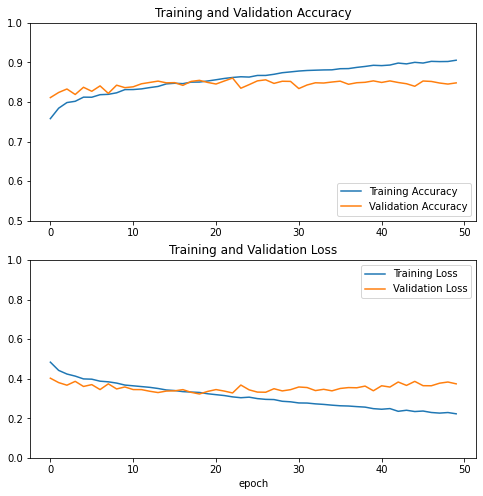

In [18]:
# Accuracy and Loss graphs for ResNet50
plot_acc_loss_graph(history_res)

## Confusion Matrix

In [2]:
# ============================================================================
## For all testing sets
# ============================================================================
# Classification reports and confusion matrices for MobileNet
# cr_mobile_all, cm_mobile_all = gen_save_cr_cm('mobile') # Both
# cr_mobile_male, cm_mobile_male = gen_save_cr_cm('mobile', 'male')
# cr_mobile_female, cm_mobile_female = gen_save_cr_cm('mobile', 'female')

# Classification reports and confusion matrices for DenseNet
# cr_dense_all, cm_dense_all = gen_save_cr_cm('dense') # Both
# cr_dense_male, cm_dense_male = gen_save_cr_cm('dense', 'male')
# cr_dense_female, cm_dense_female = gen_save_cr_cm('dense', 'female')

# Classification reports and confusion matrices for ResNet
# cr_res_all, cm_res_all = gen_save_cr_cm('res') # Both
# cr_res_male, cm_res_male = gen_save_cr_cm('res', 'male')
# cr_res_female, cm_res_female = gen_save_cr_cm('res', 'female')

# ============================================================================
## For all testing set with no perturbations
# ============================================================================
# Classification reports and confusion matrices for MobileNet
# cr_mobile_all, cm_mobile_all = gen_save_cr_cm('mobile', 'ori') # Both
# cr_mobile_male, cm_mobile_male = gen_save_cr_cm('mobile', 'ori', 'male')
# cr_mobile_female, cm_mobile_female = gen_save_cr_cm('mobile', 'ori', 'female')

# Classification reports and confusion matrices for DenseNet
# cr_dense_all, cm_dense_all = gen_save_cr_cm('dense', 'ori') # Both
# cr_dense_male, cm_dense_male = gen_save_cr_cm('dense', 'ori', 'male')
# cr_dense_female, cm_dense_female = gen_save_cr_cm('dense', 'ori', 'female')

# Classification reports and confusion matrices for ResNet
# cr_res_all, cm_res_all = gen_save_cr_cm('res', 'ori') # Both
# cr_res_male, cm_res_male = gen_save_cr_cm('res', 'ori', 'male')
# cr_res_female, cm_res_female = gen_save_cr_cm('res', 'ori', 'female')

# ============================================================================
## For all testing set with glasses filter
# ============================================================================
# Classification reports and confusion matrices for MobileNet
# cr_mobile_all, cm_mobile_all = gen_save_cr_cm('mobile', 'glasses') # Both
# cr_mobile_male, cm_mobile_male = gen_save_cr_cm('mobile', 'glasses', 'male')
# cr_mobile_female, cm_mobile_female = gen_save_cr_cm('mobile', 'glasses', 'female')

# Classification reports and confusion matrices for DenseNet
# cr_dense_all, cm_dense_all = gen_save_cr_cm('dense', 'glasses') # Both
# cr_dense_male, cm_dense_male = gen_save_cr_cm('dense', 'glasses', 'male')
# cr_dense_female, cm_dense_female = gen_save_cr_cm('dense', 'glasses', 'female')

# Classification reports and confusion matrices for ResNet
# cr_res_all, cm_res_all = gen_save_cr_cm('res', 'glasses') # Both
# cr_res_male, cm_res_male = gen_save_cr_cm('res', 'glasses', 'male')
# cr_res_female, cm_res_female = gen_save_cr_cm('res', 'glasses', 'female')

# ============================================================================
## For all testing set with masked filter
# ============================================================================
# Classification reports and confusion matrices for MobileNet
# cr_mobile_all, cm_mobile_all = gen_save_cr_cm('mobile', 'masked') # Both
# cr_mobile_male, cm_mobile_male = gen_save_cr_cm('mobile', 'masked', 'male')
# cr_mobile_female, cm_mobile_female = gen_save_cr_cm('mobile', 'masked', 'female')

# Classification reports and confusion matrices for DenseNet
# cr_dense_all, cm_dense_all = gen_save_cr_cm('dense', 'masked') # Both
# cr_dense_male, cm_dense_male = gen_save_cr_cm('dense', 'masked', 'male')
# cr_dense_female, cm_dense_female = gen_save_cr_cm('dense', 'masked', 'female')

# Classification reports and confusion matrices for ResNet
# cr_res_all, cm_res_all = gen_save_cr_cm('res', 'masked') # Both
# cr_res_male, cm_res_male = gen_save_cr_cm('res', 'masked', 'male')
# cr_res_female, cm_res_female = gen_save_cr_cm('res', 'masked', 'female')

# ============================================================================
## For all testing set with makeup filter
# ============================================================================
# Classification reports and confusion matrices for MobileNet
# cr_mobile_all, cm_mobile_all = gen_save_cr_cm('mobile', 'make_up') # Both
# cr_mobile_male, cm_mobile_male = gen_save_cr_cm('mobile', 'make_up', 'male')
# cr_mobile_female, cm_mobile_female = gen_save_cr_cm('mobile', 'make_up', 'female')

# Classification reports and confusion matrices for DenseNet
# cr_dense_all, cm_dense_all = gen_save_cr_cm('dense', 'make_up') # Both
# cr_dense_male, cm_dense_male = gen_save_cr_cm('dense', 'make_up', 'male')
# cr_dense_female, cm_dense_female = gen_save_cr_cm('dense', 'make_up', 'female')

# Classification reports and confusion matrices for ResNet
# cr_res_all, cm_res_all = gen_save_cr_cm('res', 'make_up') # Both
# cr_res_male, cm_res_male = gen_save_cr_cm('res', 'make_up', 'male')
# cr_res_female, cm_res_female = gen_save_cr_cm('res', 'make_up', 'female')

Testing on female dataset (test_make_up)...: 100%|██████████| 2144/2144 [01:01<00:00, 34.87it/s]


In [5]:
def load_metrics(model_type, 
                 perturbation=gender='all'):
    """
    Loads in results from folder fyp-ma-13/fyp-models/cr_cm_results
    
    model_type : str
        Either 'mobile' (MobileNet), 'dense' (DenseNet) or 'res' (ResNet50)
    perturbation: str
        Either 'ori', 'masked', 'glasses', 'make_up' or 'all'
    """
    assert perturbation in ['ori', 'masked', 'glasses', 'make_up']
    with open("cr_cm_results/test_{}/cr_cm_{}_{}".format(perturbation, model_type, gender)) as json_file:
        data = json.load(json_file)
        data = json.loads(data)
    return data

In [8]:
# Load results

# Both
data_mobile_both = load_metrics('mobile')
data_dense_both = load_metrics('dense')
data_res_both = load_metrics('res')

# Male
data_mobile_male = load_metrics('mobile', 'male')
data_dense_male = load_metrics('dense', 'male')
data_res_male = load_metrics('res', 'male')

# Female
data_mobile_female = load_metrics('mobile', 'female')
data_dense_female = load_metrics('dense', 'female')
data_res_female = load_metrics('res', 'female')

# Findings
- Makeup improves accuracy when predicting females
- Makeup degrades accuracy of male classification quite significantly
- Masks generally degrade accuracy
- Masks degrade the accuracy of female classification harder compared to male

## Display confusion matrices

In [104]:
def plot_cm(data, key):
    cf_matrix = data[key]
    kw = key[3:].split('_')
    # Update title
    f = kw[0]
    if f == 'mobile':
        kw[0] = "MobileNetV3"
    elif f == 'dense':
        kw[0] = 'DenseNet'
    elif f == 'res':
        kw[0] = 'ResNet50'
    
    if kw[1] == 'all':
        kw[1] = 'both'
        
    kw = ' - '.join(kw)
    """
    Plots confusion matrix 
    
    cf_matrix : list
        cf_matrix is loading in from the folder fyp-ma-13/fyp-models/cr_cm_results 
    """
    cf_matrix = np.array(cf_matrix)
    f, ax = plt.subplots(nrows = 1, ncols = 1, sharex=True, figsize=(7, 5))
    # ...
    group_names = ["TN", "FP", "FN", "TP"]
    group_counts = map(round, cf_matrix.flatten())
    group_percentages = (
        f"{round(value, 2)}%" for value in cf_matrix.flatten() / np.sum(cf_matrix)
    )
    df_cm = pd.DataFrame(cf_matrix, range(2), range(2))
    df_cm.index.name = "Actual"
    df_cm.columns.name = "Predicted"
    labels = np.asarray(
        ["\n".join(map(str, v)) for v in zip(group_names, group_counts, group_percentages)]
    ).reshape(2, 2)

    plt.suptitle(kw, fontsize = 30, ha='center', va='center')
    
    sns.set(font_scale=1.4)  # for label size
    sns.heatmap(
        df_cm,
        annot=labels,
        annot_kws={"size": 15},
        cmap="YlOrBr",
        fmt="",
        xticklabels=LABELS,
        yticklabels=LABELS,
    )
    sns.set_style("darkgrid")
    plt.show()

### Both

|========================================================|


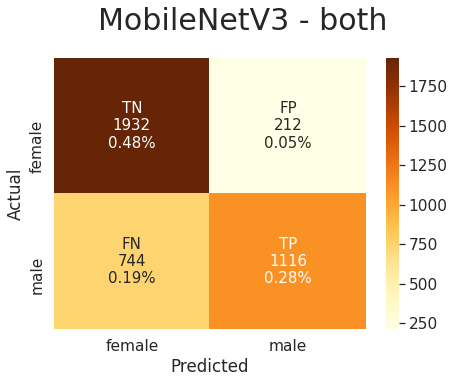

+--------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.72      0.90      0.80      2144
           1       0.84      0.60      0.70      1860

    accuracy                           0.76      4004
   macro avg       0.78      0.75      0.75      4004
weighted avg       0.78      0.76      0.75      4004

|========================================================|


In [105]:
print('|========================================================|')
plot_cm(data_mobile_both, 'cm_mobile_all')
print('+--------------------------------------------------------+')
print(data_mobile_both['cr_mobile_all'])
print('|========================================================|')

|========================================================|


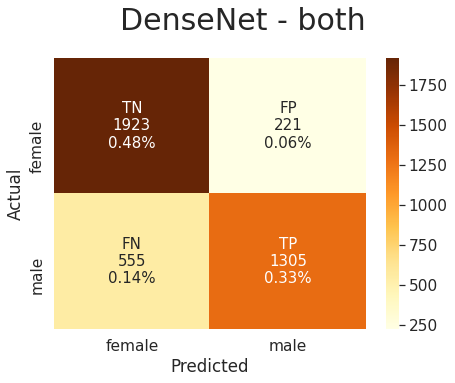

+--------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.78      0.90      0.83      2144
           1       0.86      0.70      0.77      1860

    accuracy                           0.81      4004
   macro avg       0.82      0.80      0.80      4004
weighted avg       0.81      0.81      0.80      4004

|========================================================|


In [106]:
print('|========================================================|')
plot_cm(data_dense_both, 'cm_dense_all')
print('+--------------------------------------------------------+')
print(data_dense_both['cr_dense_all'])
print('|========================================================|')

|========================================================|


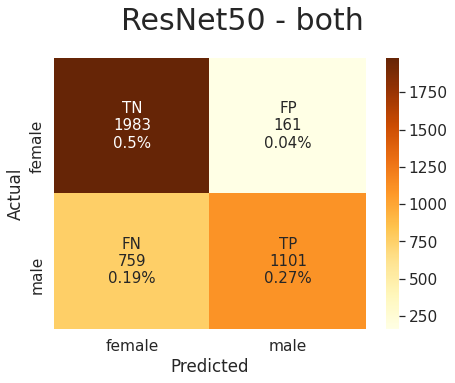

+--------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.72      0.92      0.81      2144
           1       0.87      0.59      0.71      1860

    accuracy                           0.77      4004
   macro avg       0.80      0.76      0.76      4004
weighted avg       0.79      0.77      0.76      4004

|========================================================|


In [107]:
print('|========================================================|')
plot_cm(data_res_both, 'cm_res_all')
print('+--------------------------------------------------------+')
print(data_res_both['cr_res_all'])
print('|========================================================|')

### Male

|========================================================|


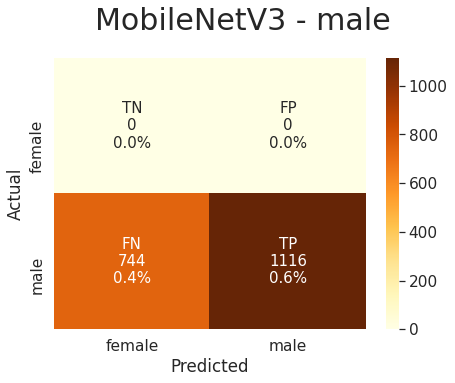

+--------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.60      0.75      1860

    accuracy                           0.60      1860
   macro avg       0.50      0.80      0.37      1860
weighted avg       1.00      0.60      0.75      1860

|========================================================|


In [108]:
print('|========================================================|')
plot_cm(data_mobile_male, 'cm_mobile_male')
print('+--------------------------------------------------------+')
print(data_mobile_male['cr_mobile_male'])
print('|========================================================|')

|========================================================|


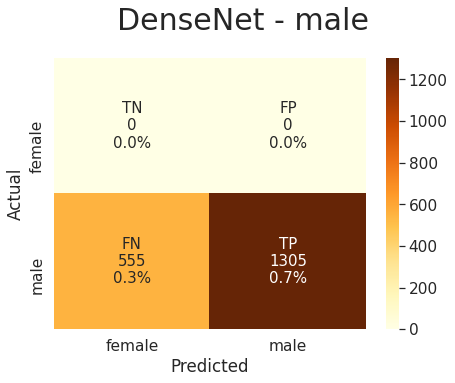

+--------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.70      0.82      1860

    accuracy                           0.70      1860
   macro avg       0.50      0.85      0.41      1860
weighted avg       1.00      0.70      0.82      1860

|========================================================|


In [109]:
print('|========================================================|')
plot_cm(data_dense_male, 'cm_dense_male')
print('+--------------------------------------------------------+')
print(data_dense_male['cr_dense_male'])
print('|========================================================|')

|========================================================|


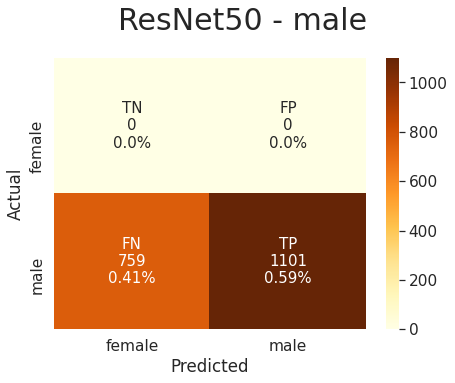

+--------------------------------------------------------+
              precision    recall  f1-score   support

           0       0.00      1.00      0.00         0
           1       1.00      0.59      0.74      1860

    accuracy                           0.59      1860
   macro avg       0.50      0.80      0.37      1860
weighted avg       1.00      0.59      0.74      1860

|========================================================|


In [110]:
print('|========================================================|')
plot_cm(data_res_male, 'cm_res_male')
print('+--------------------------------------------------------+')
print(data_res_male['cr_res_male'])
print('|========================================================|')

### Female

|========================================================|


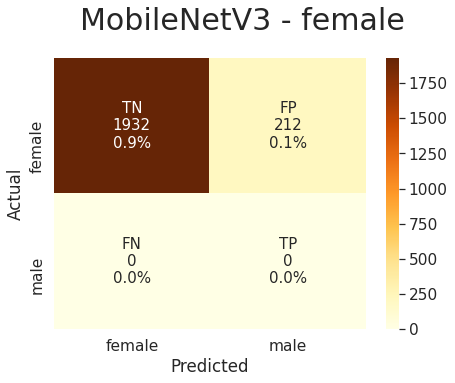

+--------------------------------------------------------+
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      2144
           1       0.00      1.00      0.00         0

    accuracy                           0.90      2144
   macro avg       0.50      0.95      0.47      2144
weighted avg       1.00      0.90      0.95      2144

|========================================================|


In [111]:
print('|========================================================|')
plot_cm(data_mobile_female, 'cm_mobile_female')
print('+--------------------------------------------------------+')
print(data_mobile_female['cr_mobile_female'])
print('|========================================================|')

|========================================================|


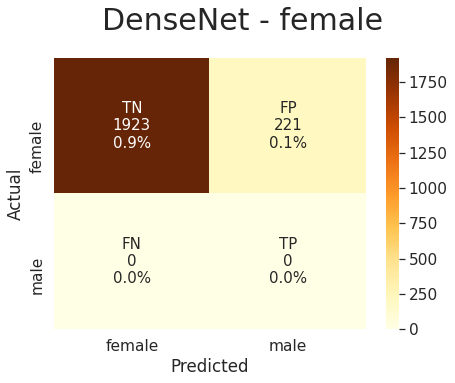

+--------------------------------------------------------+
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      2144
           1       0.00      1.00      0.00         0

    accuracy                           0.90      2144
   macro avg       0.50      0.95      0.47      2144
weighted avg       1.00      0.90      0.95      2144

|========================================================|


In [112]:
print('|========================================================|')
plot_cm(data_dense_female, 'cm_dense_female')
print('+--------------------------------------------------------+')
print(data_dense_female['cr_dense_female'])
print('|========================================================|')

|========================================================|


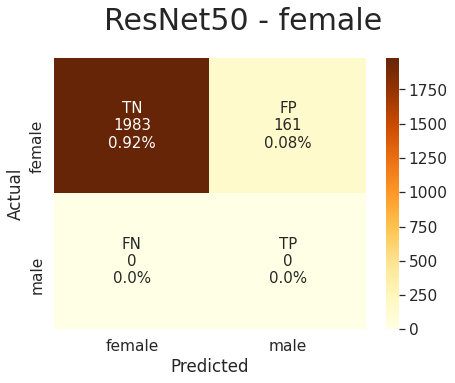

+--------------------------------------------------------+
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      2144
           1       0.00      1.00      0.00         0

    accuracy                           0.92      2144
   macro avg       0.50      0.96      0.48      2144
weighted avg       1.00      0.92      0.96      2144

|========================================================|


In [113]:
print('|========================================================|')
plot_cm(data_res_female, 'cm_res_female')
print('+--------------------------------------------------------+')
print(data_res_female['cr_res_female'])
print('|========================================================|')

## Single Predictions